In [1]:
import json
import os
import numpy as np
import time
import threading
import tkinter as tk
import torch
import model_training.config as config
import model_training.utils as utils
import inference.single_image_inference as inference
import preprocessing.preprocess_data as preprocessing
from datetime import datetime
from PIL import Image, ImageDraw, ImageTk
from mpl_toolkits.mplot3d import Axes3D
from model_training.model import YOLOv3
from inference.plot_results import plot_bounding_boxes, plot_bounding_box_single_image, ImageDisplayApp


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


# Run Inference Continuously

In [2]:
global_app = None

def run_tkinter():
    global global_app
    root = tk.Tk()
    global_app = ImageDisplayApp(root)
    root.mainloop()

current_datetime = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
run_id = f"{config.INFERENCE_RUN_TITLE}_{current_datetime}"

# Create a folder for the run_id inside 'inference/inference_results/'
results_folder = os.path.join(config.INFERENCE_RESULTS_FOLDER, run_id)
processed_pcd_folder = config.INFERENCE_PROCESSED_PCD_FOLDER
results_file_path = os.path.join(results_folder, f"results_{run_id}.json")
os.makedirs(results_folder, exist_ok=True)
os.makedirs(processed_pcd_folder, exist_ok=True)

if config.INFERENCE_SHOW_LIVE_RESULTS:
    tkinter_thread = threading.Thread(target=run_tkinter)
    tkinter_thread.start()

model = YOLOv3(num_classes=config.NUM_CLASSES).to(config.DEVICE)
utils.load_checkpoint(
            config.INFERENCE_CHECKPOINT_FILE, model, None, None
        )
# Inference loop
print(f"Waiting for pcd files in {config.RAW_PCD_FOLDER}")
while True:
    # Monitor the folder for new point cloud files
    for file_name in os.listdir(config.INFERENCE_PCD_FOLDER):
        print(file_name)
        if file_name.endswith(".pcd"):
            # Transform point cloud to BEV image
            bev_image = preprocessing.transform_to_bev(file_name)

            # Extract x, y coordinates from YOLO v3 output
            bboxes_pred = inference.inference_single_image(model, bev_image)

            # Print results to console
            print(f"File: {file_name}, bboxes: {bboxes_pred}")

            result_dict = {}
            for idx in range(len(bboxes_pred)):
                bbox_info = {
                    "confidence": bboxes_pred[idx][2],
                    "x": bboxes_pred[idx][3],
                    "y": bboxes_pred[idx][4],
                    "w": bboxes_pred[idx][5],
                    "h": bboxes_pred[idx][6]
                }
                result_dict[idx] = bbox_info

            # Create a dictionary to store all results
            results = {}

            # Check if the results file already exists
            if os.path.exists(results_file_path):
                # Read existing results from the file
                with open(results_file_path, 'r') as json_file:
                    results = json.load(json_file)

            # Add new results to the dictionary
            results[file_name] = result_dict

            if config.INFERENCE_SHOW_LIVE_RESULTS:
                plot_bounding_box_single_image(result_dict, config.INFERENCE_TEMP_BEV_FOLDER, file_name, global_app)

            # Write all results back to the file
            with open(results_file_path, "w") as json_file:
                json.dump(results, json_file, indent=2)

            # Optional: Move processed file to another folder to avoid re-processing
            os.rename(os.path.join(config.INFERENCE_PCD_FOLDER, file_name),
                      os.path.join(processed_pcd_folder, file_name))

    # Sleep for a while before checking for new files again
    time.sleep(0.01)

=> Loading checkpoint: inference/model/inference_model_checkpoint.pth.tar
Waiting for pcd files in label_cloud_project/datastore/pointclouds/raw_pcds
000003.pcd
Image saved at inference/temp/bev_images\000003.png
Using device: cuda


100%|██████████| 1/1 [00:10<00:00, 10.06s/it]

Starting NMS
Num boxes above confidence threshold: 10
Highest Box confidence scores: [0.8072582483291626, 0.8008938431739807, 0.794102132320404, 0.7910056710243225, 0.7829733490943909]


100%|██████████| 1/1 [00:10<00:00, 10.44s/it]


File: 000003.pcd, bboxes: [[0, 0.0, 0.8072582483291626, 0.6199800968170166, 0.33954012393951416, 0.028397424146533012, 0.027723390609025955], [0, 0.0, 0.794102132320404, 0.4294567406177521, 0.37492313981056213, 0.028056034818291664, 0.02645588293671608], [0, 0.0, 0.7910056710243225, 0.4263358414173126, 0.2921159863471985, 0.028664518147706985, 0.028390057384967804], [0, 0.0, 0.7829733490943909, 0.6131014227867126, 0.43788930773735046, 0.026792213320732117, 0.026564495638012886], [0, 0.0, 0.7641777396202087, 0.4271423816680908, 0.432146817445755, 0.02818937413394451, 0.027177639305591583]]
000004.pcd
Image saved at inference/temp/bev_images\000004.png
Using device: cuda


100%|██████████| 1/1 [00:09<00:00,  9.51s/it]

Starting NMS
Num boxes above confidence threshold: 11
Highest Box confidence scores: [0.8299436569213867, 0.824759304523468, 0.8069045543670654, 0.8013520836830139, 0.8003425598144531]


100%|██████████| 1/1 [00:09<00:00,  9.89s/it]


File: 000004.pcd, bboxes: [[0, 0.0, 0.8299436569213867, 0.6207255721092224, 0.3393271267414093, 0.026913324370980263, 0.02635212615132332], [0, 0.0, 0.8069045543670654, 0.428894966840744, 0.37448444962501526, 0.027293629944324493, 0.02590077556669712], [0, 0.0, 0.8013520836830139, 0.6129134297370911, 0.4376993477344513, 0.026676852256059647, 0.02681625820696354], [0, 0.0, 0.8003425598144531, 0.42597758769989014, 0.29200875759124756, 0.028095433488488197, 0.02794303372502327], [0, 0.0, 0.7333654761314392, 0.4269472658634186, 0.43126749992370605, 0.028276219964027405, 0.027415188029408455]]
000005.pcd
Image saved at inference/temp/bev_images\000005.png
Using device: cuda


100%|██████████| 1/1 [00:09<00:00,  9.44s/it]

Starting NMS
Num boxes above confidence threshold: 13
Highest Box confidence scores: [0.8456155061721802, 0.8389489650726318, 0.8136775493621826, 0.791598916053772, 0.7881207466125488]


100%|██████████| 1/1 [00:09<00:00,  9.83s/it]


File: 000005.pcd, bboxes: [[0, 0.0, 0.8456155061721802, 0.6202619671821594, 0.3397262394428253, 0.027471937239170074, 0.026937486603856087], [0, 0.0, 0.8136775493621826, 0.42864885926246643, 0.37475278973579407, 0.027212966233491898, 0.025968434289097786], [0, 0.0, 0.791598916053772, 0.6124739050865173, 0.4379151463508606, 0.027056463062763214, 0.026983143761754036], [0, 0.0, 0.7881207466125488, 0.4258177578449249, 0.2921757698059082, 0.028848830610513687, 0.02836523950099945], [0, 0.0, 0.7778000831604004, 0.42670518159866333, 0.43271127343177795, 0.027141619473695755, 0.02731464058160782], [0, 0.0, 0.7280308604240417, 0.4677417278289795, 0.22481293976306915, 0.03291312977671623, 0.03196822479367256], [0, 0.0, 0.7113497257232666, 0.5802783966064453, 0.2078760266304016, 0.028882743790745735, 0.028339805081486702]]
000006.pcd
Image saved at inference/temp/bev_images\000006.png
Using device: cuda


  0%|          | 0/1 [00:04<?, ?it/s]


KeyboardInterrupt: 

## Plot all results on top of BEV images

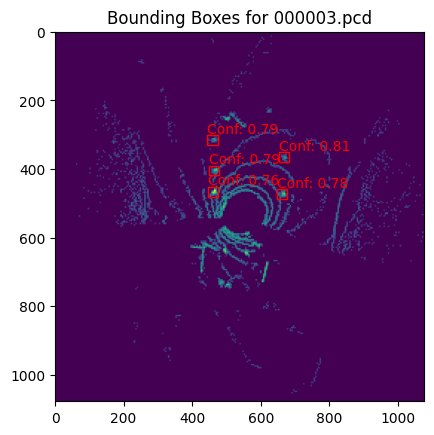

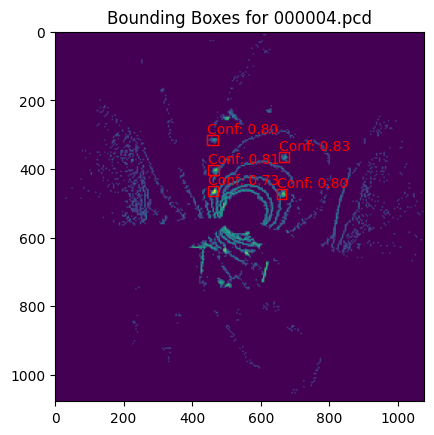

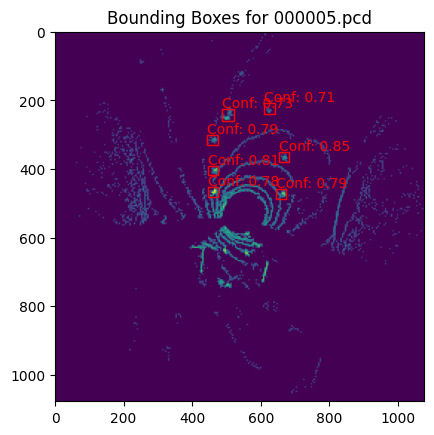

In [3]:
plot_bounding_boxes(results_file_path, config.INFERENCE_TEMP_BEV_FOLDER)